# Exit Survey Analysis

This analysis will explore reasons that both younger and older employees are leaving their jobs, as well as newer or more experienced employees (and why they are leaving their jobs).

In [1]:
# import pandas and read the csv file into a dataframe
import pandas as pd
dete_survey = pd.read_csv('dete_survey.csv')
tafe_survey = pd.read_csv('tafe_survey.csv')

# ignore Jupyter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# explore the data frames

# tafe_survey.info()
# dete_survey.isnull().sum()
# tafe_survey['column'].value_counts()
# tafe_survey.head()
dete_survey.shape

(822, 56)

The DETE survey data set contains 822 rows and 56 columns. Many of the columns are reasons for exiting employment. There are 18 Bool columns, which indicated True or False for a reason the employee left. There are also 37 string columns that appear to contain codes, such as 'A', 'AS', etc. There are various columns in the DETE data set that have (in some cases) hundreds of NULL values.

The TAFE data set contains 702 rows and 72 columns. Many of the columns are labeled as questions and contain string data types for the response to the question, which appear to contain Yes or No answers. The TAFE data set also contains several columns which have over 100 NULL values.

In [3]:
# read DETE survey results back into a dataframe, but read 'Not Stated' as NaN
dete_survey = pd.read_csv('dete_survey.csv', na_values='Not Stated')
tafe_survey = pd.read_csv('tafe_survey.csv', na_values='Not Stated')
# drop columns not needed for the analysis and save new data frames
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis=1)
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis=1)

Above, several columns were dropped from both data sets that were not being used in the analysis.

In [4]:
# update column names to be consitent in both data sets
dete_survey_updated.columns = dete_survey_updated.columns.str.lower().str.replace(' ', '_').str.strip()
tafe_survey_updated.rename(columns={
    'Record ID':'id',
    'CESSATION YEAR':'cease_date',
    'Reason for ceasing employment':'separationtype',
    'Gender. What is your Gender?':'gender',
    'CurrentAge. Current Age':'age',
    'Employment Type. Employment Type':'employment_status',
    'Classification. Classification':'position',
    'LengthofServiceOverall. Overall Length of Service at Institute (in years)':'institute_service',
    'LengthofServiceCurrent. Length of Service at current workplace (in years)':'role_service'
}, inplace=True)

In [5]:
# explore the newly named columns
tafe_survey_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 23 columns):
id                                                     702 non-null float64
Institute                                              702 non-null object
WorkArea                                               702 non-null object
cease_date                                             695 non-null float64
separationtype                                         701 non-null object
Contributing Factors. Career Move - Public Sector      437 non-null object
Contributing Factors. Career Move - Private Sector     437 non-null object
Contributing Factors. Career Move - Self-employment    437 non-null object
Contributing Factors. Ill Health                       437 non-null object
Contributing Factors. Maternity/Family                 437 non-null object
Contributing Factors. Dissatisfaction                  437 non-null object
Contributing Factors. Job Dissatisfaction              437 non-null 

In the cell above, the columns were renamed to be more clear, descriptive, and easier to handle

In [6]:
# review unique values in the 'separationtype' column
tafe_survey_updated['separationtype'].value_counts(dropna=False)

Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
NaN                           1
Name: separationtype, dtype: int64

In [7]:
# create new data frames containing only 'Resignation' separations
dete_resignations = dete_survey_updated[dete_survey_updated['separationtype'].str.contains('Resignation')]
tafe_resignations = tafe_survey_updated[tafe_survey_updated['separationtype'].str.contains('Resignation', na=False)]

# validate the results
tafe_resignations['separationtype'].value_counts()

Resignation    340
Name: separationtype, dtype: int64

The cell above created 2 new data frams that contain only records where the 'separationtype' contains the string 'Resigned', so that we can analyze the contributing factors specific to resignation

In [8]:
# check for logical inconsistencies in the date columns
dete_resignations['cease_date'].value_counts()

2012       126
2013        74
01/2014     22
12/2013     17
06/2013     14
09/2013     11
11/2013      9
07/2013      9
10/2013      6
08/2013      4
05/2012      2
05/2013      2
07/2006      1
07/2012      1
2010         1
09/2010      1
Name: cease_date, dtype: int64

In [9]:
# clean the date column
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.extract(r'(20[0-1][0-9])').astype(float)

# verify the cleaning
dete_resignations['cease_date'].value_counts()

2013.0    146
2012.0    129
2014.0     22
2010.0      2
2006.0      1
Name: cease_date, dtype: int64

In [10]:
# check unique values for date columns
#dete_resignations['cease_date'].value_counts()
#dete_resignations['dete_start_date'].value_counts()
tafe_resignations['cease_date'].value_counts()

2011.0    116
2012.0     94
2010.0     68
2013.0     55
2009.0      2
Name: cease_date, dtype: int64

After cleaning the date columns, the dates make logical sense for both data sets.

In [11]:
# create a corresponding years of service column in the DETE data set to reflect the TAFE data set structure
dete_resignations['institute_service'] = dete_resignations['cease_date'] - dete_resignations['dete_start_date']

A new columna called 'institute_service' has been added to the DETE data set to reflect the column structure of the TAFE data set

In [12]:
# verify the values
#tafe_resignations['Contributing Factors. Dissatisfaction'].value_counts()
tafe_resignations['Contributing Factors. Job Dissatisfaction'].head()

3    -
4    -
5    -
6    -
7    -
Name: Contributing Factors. Job Dissatisfaction, dtype: object

In [15]:
import numpy as np

# define function to update columns to contain True, False, or NaN values
def update_vals(elem):
    if pd.isnull(elem):
        return np.nan
    elif elem == '-':
        return False
    else:
        return True

In [16]:
# create new dissatisfied column in both data sets
tafe_resignations['dissatisfied'] = tafe_resignations[['Contributing Factors. Dissatisfaction', 'Contributing Factors. Job Dissatisfaction']].applymap(update_vals).any(axis=1, skipna=False)
dete_resignations['dissatisfied'] = dete_resignations[['job_dissatisfaction',
'dissatisfaction_with_the_department',
'physical_work_environment',
'lack_of_recognition',
'lack_of_job_security',
'work_location',
'employment_conditions',
'work_life_balance',
'workload']].any(axis=1, skipna=False)

# create a copy of the results
dete_resignations_up = dete_resignations.copy()
tafe_resignations_up = tafe_resignations.copy()

In [17]:
# check the values for each data frame
dete_resignations_up['dissatisfied'].value_counts(dropna=False)

False    162
True     149
Name: dissatisfied, dtype: int64

Both data sets now have a 'dissatisfied' column that indicates whether an employee resigned due to dissatisfaction, or another reason.

In [18]:
# add new columns to each data frame to identify the source of the data
dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'

# combine the data sets into 1 data frame
combined = pd.concat([dete_resignations_up, tafe_resignations_up])

In [19]:
# drop any columns with less than 500 non null values
combined_updated = combined.dropna(axis=1, thresh=500)

The cells above combined the data sets into 1, as well as dropped any columns that have fewer than 500 non null vales. There is also a new column in the data set that helps identify the source of the data.

In [20]:
# display unique values for a column
# combined_updated['institute_service'].value_counts(dropna=False)

# transform each value into a string for the 'institute_service' column
combined_updated['institute_service'] = combined_updated['institute_service'].astype(str)

In [21]:
# check new string values
combined_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651 entries, 3 to 701
Data columns (total 10 columns):
age                  596 non-null object
cease_date           635 non-null float64
dissatisfied         643 non-null object
employment_status    597 non-null object
gender               592 non-null object
id                   651 non-null float64
institute            651 non-null object
institute_service    651 non-null object
position             598 non-null object
separationtype       651 non-null object
dtypes: float64(2), object(8)
memory usage: 55.9+ KB


In [22]:
# create 1 year value from all the strings
import re
combined_updated['institute_service'] = combined_updated['institute_service'].str.replace('More than', '')
combined_updated['institute_service'] = combined_updated['institute_service'].str.replace('Less than', '')
combined_updated['institute_service'] = combined_updated['institute_service'].str.replace('years', '')
combined_updated['institute_service'] = combined_updated['institute_service'].str.replace('year', '')
combined_updated['institute_service'] = combined_updated['institute_service'].str.extract(r'(\d+)')

In [23]:
# check new string values
combined_updated['institute_service'].value_counts(dropna=False)

1      159
NaN     88
3       83
5       56
7       34
11      30
0       20
20      17
6       17
4       16
2       14
9       14
8        8
13       8
15       7
12       6
17       6
14       6
22       6
10       6
18       5
16       5
24       4
23       4
21       3
32       3
39       3
19       3
25       2
26       2
30       2
28       2
36       2
27       1
35       1
42       1
34       1
29       1
49       1
41       1
33       1
38       1
31       1
Name: institute_service, dtype: int64

In [24]:
# convert the institute_service column to float data type
combined_updated['institute_service'] = combined_updated['institute_service'].astype(float)

In [25]:
# map each years of service value to a category
def define_category(elem):
    if elem < 3:
        return 'New'
    elif elem >= 3 and elem <= 6:
        return 'Experienced'
    elif elem >= 7 and elem <=10:
        return 'Established'
    elif elem >= 11:
        return 'Veteran'
    elif pd.isnull(elem):
        return np.nan
    
# apply the function to the institute_service column and create new column with results
combined_updated['service_cat'] = combined_updated['institute_service'].apply(define_category)

In [26]:
# check the results in the series
combined_updated['service_cat'].value_counts(dropna=False)

New            193
Experienced    172
Veteran        136
NaN             88
Established     62
Name: service_cat, dtype: int64

As seen above, a new column in the data set has been created that defines which service category that a worker belongs to, based on their years of service.

In [27]:
# confirm number of satisfied or dissatisfied exits
combined_updated['dissatisfied'].value_counts(dropna=False)

False    403
True     240
NaN        8
Name: dissatisfied, dtype: int64

In [28]:
# populate null values in the 'dissatisfied' column with False, since it occurs most frequently
combined_updated['dissatisfied'] = combined_updated['dissatisfied'].fillna(False)

In [29]:
# create a pivot table of the data
table = combined_updated.pivot_table(index='service_cat', values='dissatisfied')

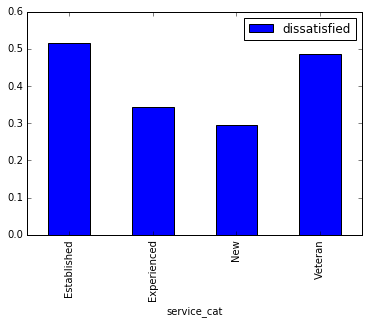

In [30]:
%matplotlib inline
table.plot(kind='bar')

As you can see in the visualization above, generally, more experienced workers have a higher rate of any sort of dissatisfaction.